In [1]:
import numpy as np
import hnumpy as hnp
import torch
import pandas as pd
import random
import matplotlib.pyplot as plt
from time import time

In [2]:
torch.random.manual_seed(73)
random.seed(73)


def split_train_test(x, y, test_ratio=0.3):
    idxs = [i for i in range(len(x))]
    random.shuffle(idxs)
    # delimiter between test and train data
    delim = int(len(x) * test_ratio)
    test_idxs, train_idxs = idxs[:delim], idxs[delim:]
    return x[train_idxs], y[train_idxs], x[test_idxs], y[test_idxs]


def heart_disease_data():
    data = pd.read_csv("./data/framingham.csv")
    # drop rows with missing values
    data = data.dropna()
    # drop some features
    data = data.drop(columns=["education", "currentSmoker", "BPMeds", "diabetes", "diaBP", "BMI"])
    # balance data
    grouped = data.groupby('TenYearCHD')
    data = grouped.apply(lambda x: x.sample(grouped.size().min(), random_state=73).reset_index(drop=True))
    # extract labels
    y = torch.tensor(data["TenYearCHD"].values).float().unsqueeze(1)
    data = data.drop("TenYearCHD", 'columns')
    # standardize data
    data = (data - data.mean()) / data.std()
    x = torch.tensor(data.values).float()
    return split_train_test(x, y)

x_train, y_train, x_test, y_test = heart_disease_data()

In [3]:
# define the number of epochs for both plain and encrypted training
EPOCHS = 5


class LR(torch.nn.Module):

    def __init__(self, n_features):
        super(LR, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)
        
    def forward(self, x):
        out = torch.sigmoid(self.lr(x))
        return out
    
    
def train(model, optim, criterion, x, y, epochs=EPOCHS):
    for e in range(1, epochs + 1):
        optim.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optim.step()
        print(f"Loss at epoch {e}: {loss.data}")
    return model
    

n_features = x_train.shape[1]
model = LR(n_features)
# use gradient descent with a learning_rate=1
optim = torch.optim.SGD(model.parameters(), lr=1)
# use Binary Cross Entropy Loss
criterion = torch.nn.BCELoss()

In [4]:
model = train(model, optim, criterion, x_train, y_train)

Loss at epoch 1: 0.8504331707954407
Loss at epoch 2: 0.6863385438919067
Loss at epoch 3: 0.6358115077018738
Loss at epoch 4: 0.6193529367446899
Loss at epoch 5: 0.6124349236488342


## Encrypted inference

In [5]:
# extract weights from model
w = np.array(model.lr.weight.flatten().tolist())
b = model.lr.bias.flatten().tolist()[0]

In [6]:
# use [-1, 1] because of normalization
DATA_RANGE = (-1., 1.)

INPUT_SIZE = x_test.shape[1]

In [7]:
def plain_inference(x):
    x = np.dot(x, w) + b
    return 1 / (1 + np.exp(-x))

# compile the function
h = hnp.compile_fhe(
    plain_inference,
    {"x": hnp.encrypted_ndarray(bounds=DATA_RANGE, shape=(INPUT_SIZE,))},
)

2021-06-02 11:31:24.687 | INFO     | hnumpy.convert:compile_fhe:360 - Compiling plain_inference into an FHE function
2021-06-02 11:31:24.688 | INFO     | hnumpy.convert:compile_fhe:362 - Checking input and output
2021-06-02 11:31:24.690 | INFO     | hnumpy.convert:compile_homomorphic:253 - Create target graph
2021-06-02 11:31:24.692 | INFO     | hnumpy.convert:compile_homomorphic:258 - Optimize target graph with optimizer `handselected`
2021-06-02 11:31:24.702 | INFO     | hnumpy.convert:compile_homomorphic:271 - Correct encoding
2021-06-02 11:31:24.703 | INFO     | hnumpy.convert:compile_homomorphic:274 - Create VM graph
2021-06-02 11:31:24.705 | INFO     | hnumpy.convert:compile_homomorphic:290 - Return the result to the caller


In [8]:
context = h.create_context()
keys = context.keygen()

2021-06-02 11:31:24.713 | INFO     | hnumpy.client:keygen:28 - Creating 0 keyswitching key(s) and 1 bootstrapping key(s). This should take approximately 30 seconds (0.5 minutes)
2021-06-02 11:31:59.692 | DEBUG    | hnumpy.client:keygen:42 - Key creation time took 34.978072094000005 seconds


In [9]:
# run encrypted inference / plain inference
x = np.array(x_test[0].tolist())
h_result = h.encrypt_and_run(keys, x)[0]
expected_result = plain_inference(x)
print(f"encrypted result: {h_result}")
print(f"plain result: {expected_result}")

encrypted result: 0.30971041252842174
plain result: 0.31867577660459656


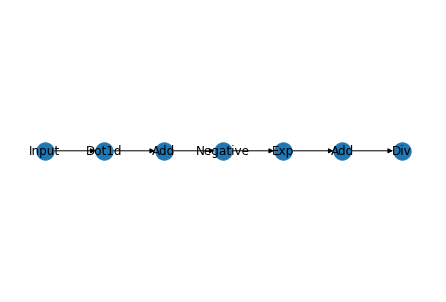

In [10]:
h.draw_intermediate_graph()

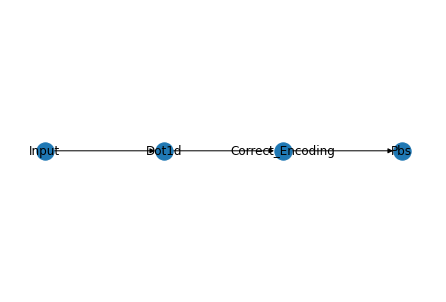

In [11]:
h.draw_intermediate_graph()

In [12]:
plain_outputs = []
encrypted_outputs = []

# encrypted
tick = time()
for x in x_test:
    x = np.array(x.tolist())
    h_result = h.encrypt_and_run(keys, x)[0]
    encrypted_outputs.append(h_result)
tock = time()
print(f"took {tock - tick:0.2f}sec ({(tock - tick) / len(x_test)}sec per inference) to evaluate the test set homomorphically ({len(encrypted_outputs)} examples)")

# plain
for x in x_test:
    x = np.array(x.tolist())
    expected_result = plain_inference(x)
    plain_outputs.append(expected_result)

took 39.18sec (0.11731217721265233sec per inference) to evaluate the test set homomorphically (334 examples)


Difference between plain and encrypted outputs:
mean / std = 0.013759283037795687 / 0.08014240358942079
max / min = 0.8777918911117742 / 3.587512807490256e-05
count of > 0.1 = 3


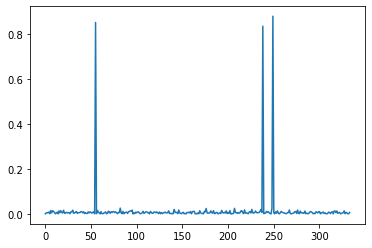

In [13]:
diff = np.abs(np.array(plain_outputs) - np.array(encrypted_outputs))
print("Difference between plain and encrypted outputs:")
print(f"mean / std = {diff.mean()} / {diff.std()}")
print(f"max / min = {diff.max()} / {diff.min()}")
print(f"count of > 0.1 = {np.sum(diff > 0.1)}")
_ = plt.plot(diff)

In [14]:
def accuracy(y_out, y_correct):
    labels = (np.array(y_out) >= 0.5).astype(np.float64)
    return np.sum(labels == y_correct) / len(y_correct)

correct = np.array(y_test.flatten().tolist())
plain_acc = accuracy(plain_outputs, correct)
enc_acc = accuracy(encrypted_outputs, correct)
print(f"Accuracies: plain = {int(plain_acc * 100)}% / encrypted = {int(enc_acc * 100)}% (diff = {plain_acc - enc_acc})")

Accuracies: plain = 70% / encrypted = 69% (diff = 0.011976047904191711)
